# 탄소배출권 가격 예측 프로그램

- 사용 데이터 : 종가, 시가, 고가, 저가, 거래량, 거래대금, 변환 날짜, 대비
- 2015년부터 2020년 6월까지의 데이터를 사용하여 모델 생성
- 생성한 모델로 2020년 7월부터 8월까지의 데이터를 테스트, 정확도 비교

## 1. 데이터 임포트

In [219]:
def del_comma(df):
    df['end_pr'] = df['end_pr'].apply(lambda x:str(x).replace(',', ''))
    df['diff'] = df['diff'].apply(lambda x:str(x).replace(',', ''))
    df['start_pr'] = df['start_pr'].apply(lambda x:str(x).replace(',', ''))
    df['high_pr'] = df['high_pr'].apply(lambda x:str(x).replace(',', ''))
    df['low_pr'] = df['low_pr'].apply(lambda x:str(x).replace(',', ''))
    df['volume'] = df['volume'].apply(lambda x:str(x).replace(',', ''))
    df['sum_pr'] = df['sum_pr'].apply(lambda x:str(x).replace(',', ''))
    return df


import pandas as pd
kau19 = pd.read_excel('KAU19.xls'
                      , names=['date', 'end_pr', 'diff', 'diff_per','start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', '_', '__', '___']
                      , convert_float=False)
kau19 = kau19.loc[:, 'date':'sum_pr']
kau19 = del_comma(kau19)
#print(kau19.info())
#print(kau19.head())

kau20 = pd.read_excel('KAU20.xls',
                      names=['date', 'end_pr', 'diff', 'diff_per','start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', '_', '__', '___']
                     , convert_float=False)
kau20 = kau20.loc[:, 'date':'sum_pr']
kau20 = del_comma(kau20)
#print(kau20.head())
#print(kau20.tail())

## 2. 데이터 분리, 전처리
- 학습할 데이터와 테스트 데이터 분리
- 2020년 6월 이전까지의 데이터를 사용해서 학습
- 2020년 6월 이후 데이터를 사용해서 테스트
- 거래가 일어나지 않은 날은 제외
- 날짜 데이터를 시작 일에 대한 weight를 생성
    -> 특정 시점 이후 거래가 활발해지는 배출권 거래 시장을 반영하기 위함
- 정규화
 

In [220]:
def check_sign(diff, diff_per):
    diff = str(diff)
    if(diff_per<0):
        if(diff[0]!='-'):
            return '-'+diff
        #print(row)
        #print('::::::::::::::::::::::')
    return diff

kau19['diff']=kau19.apply(lambda x:check_sign(x['diff'], x['diff_per']), axis=1)
kau20['diff']=kau20.apply(lambda x:check_sign(x['diff'], x['diff_per']), axis=1)

#print(kau19.head())
#print(kau20.head())

In [221]:
def check_start_high_low(pr, end_pr):
    if(pr=='-'):
        #print(row['start_pr'], row['end_pr'])
        return end_pr
    return pr

kau19['start_pr']=kau19.apply(lambda x:check_start_high_low(x['start_pr'], x['end_pr']), axis=1)
kau19['high_pr']=kau19.apply(lambda x:check_start_high_low(x['high_pr'], x['end_pr']), axis=1)
kau19['low_pr']=kau19.apply(lambda x:check_start_high_low(x['low_pr'], x['end_pr']), axis=1)
kau20['start_pr']=kau20.apply(lambda x:check_start_high_low(x['start_pr'], x['end_pr']), axis=1)
kau20['high_pr']=kau20.apply(lambda x:check_start_high_low(x['high_pr'], x['end_pr']), axis=1)
kau20['low_pr']=kau20.apply(lambda x:check_start_high_low(x['low_pr'], x['end_pr']), axis=1)

#print(kau19.head())
#print(kau20.head())

In [224]:
import numpy as np
def set_weight(df):
    df.sort_values(by=['date'], inplace=True)
    df['wei'] = np.arange(1, len(df.index)+1,1,dtype=object)
    return df
kau19 = set_weight(kau19)
kau20 = set_weight(kau20)
print(kau19.head(80))
#print(kau20.head())

           date end_pr diff  diff_per start_pr high_pr low_pr volume sum_pr  \
441  2018/11/08  23200    0       0.0    23200   23200  23200      0      0   
440  2018/11/09  23200    0       0.0    23200   23200  23200      0      0   
439  2018/11/12  23200    0       0.0    23200   23200  23200      0      0   
438  2018/11/13  23200    0       0.0    23200   23200  23200      0      0   
437  2018/11/14  23200    0       0.0    23200   23200  23200      0      0   
..          ...    ...  ...       ...      ...     ...    ...    ...    ...   
366  2019/03/04  26050    0       0.0    26050   26050  26050      0      0   
365  2019/03/05  26050    0       0.0    26050   26050  26050      0      0   
364  2019/03/06  26050    0       0.0    26050   26050  26050      0      0   
363  2019/03/07  26050    0       0.0    26050   26050  26050      0      0   
362  2019/03/08  26050    0       0.0    26050   26050  26050      0      0   

    wei  
441   1  
440   2  
439   3  
438   4  
4

In [225]:
def set_float(df):
    df['end_pr'] = df['end_pr'].astype(float)
    df['diff'] = df['diff'].astype(float)
    df['start_pr'] = df['start_pr'].astype(float)
    df['high_pr'] = df['high_pr'].astype(float)
    df['low_pr'] = df['low_pr'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['sum_pr'] = df['sum_pr'].astype(float)
    df['wei'] = df['wei'].astype(float)
    return df
kau19_float = set_float(kau19)
kau20_float = set_float(kau20)
#print(kau19_float.info())
print(kau19_float.head(80))

           date   end_pr  diff  diff_per  start_pr  high_pr   low_pr  volume  \
441  2018/11/08  23200.0   0.0       0.0   23200.0  23200.0  23200.0     0.0   
440  2018/11/09  23200.0   0.0       0.0   23200.0  23200.0  23200.0     0.0   
439  2018/11/12  23200.0   0.0       0.0   23200.0  23200.0  23200.0     0.0   
438  2018/11/13  23200.0   0.0       0.0   23200.0  23200.0  23200.0     0.0   
437  2018/11/14  23200.0   0.0       0.0   23200.0  23200.0  23200.0     0.0   
..          ...      ...   ...       ...       ...      ...      ...     ...   
366  2019/03/04  26050.0   0.0       0.0   26050.0  26050.0  26050.0     0.0   
365  2019/03/05  26050.0   0.0       0.0   26050.0  26050.0  26050.0     0.0   
364  2019/03/06  26050.0   0.0       0.0   26050.0  26050.0  26050.0     0.0   
363  2019/03/07  26050.0   0.0       0.0   26050.0  26050.0  26050.0     0.0   
362  2019/03/08  26050.0   0.0       0.0   26050.0  26050.0  26050.0     0.0   

     sum_pr   wei  
441     0.0   1.0  

In [226]:
from sklearn.preprocessing import MinMaxScaler

def scale(df):
    scaler = MinMaxScaler()
    scale_cols = ['end_pr', 'diff', 'diff_per', 'start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', 'wei']
    df_scaled = scaler.fit_transform(df[scale_cols])
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols
    return df_scaled

scaled_kau19 = scale(kau19_float)
scaled_kau20 = scale(kau20_float)
scaled_kau19['date'] = kau19_float['date']
scaled_kau20['date'] = kau20_float['date']
print(scaled_kau19.head(80))
#print(scaled_kau20.head())

      end_pr      diff  diff_per  start_pr   high_pr    low_pr  volume  \
0   0.316602  0.606299       0.5  0.336449  0.315992  0.337079     0.0   
1   0.316602  0.606299       0.5  0.336449  0.315992  0.337079     0.0   
2   0.316602  0.606299       0.5  0.336449  0.315992  0.337079     0.0   
3   0.316602  0.606299       0.5  0.336449  0.315992  0.337079     0.0   
4   0.316602  0.606299       0.5  0.336449  0.315992  0.337079     0.0   
..       ...       ...       ...       ...       ...       ...     ...   
75  0.426641  0.606299       0.5  0.442991  0.425819  0.443820     0.0   
76  0.426641  0.606299       0.5  0.442991  0.425819  0.443820     0.0   
77  0.426641  0.606299       0.5  0.442991  0.425819  0.443820     0.0   
78  0.426641  0.606299       0.5  0.442991  0.425819  0.443820     0.0   
79  0.426641  0.606299       0.5  0.442991  0.425819  0.443820     0.0   

    sum_pr       wei        date  
0      0.0  0.000000  2020/08/21  
1      0.0  0.002268  2020/08/20  
2     

In [227]:
BASE = '2020/06/15'

drop_kau19 = scaled_kau19[:][kau19.volume != '0']
drop_kau20 = scaled_kau20[:][kau20.volume != '0']
X_19 = drop_kau19[['date', 'diff', 'diff_per', 'start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', 'wei']]
X_20 = drop_kau20[['date', 'diff', 'diff_per', 'start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', 'wei']]
X_20_train = X_20[:][X_20.date < BASE]
X_20_test = X_20[:][X_20.date >= BASE]

X_train = pd.concat([X_19, X_20_train], ignore_index=True, axis=0)
X_train = X_train.loc[:,'diff' : 'wei']
X_test = X_20_test.loc[:, 'diff' : 'wei']
#print(X_train.head(50))
#print(X_train.info())

Y_19 = drop_kau19[['date', 'end_pr']]
Y_20 = drop_kau20[['date', 'end_pr']]
Y_20_train = Y_20[:][Y_20.date < BASE]
Y_20_test = Y_20[:][Y_20.date >= BASE]

Y_train = pd.concat([Y_19, Y_20_train], ignore_index=True, axis=0)
Y_train = Y_train.loc[:, 'end_pr']
Y_test = Y_20_test.loc[:, 'end_pr']
#print(Y_train.head())

C:\Users\johnh\anaconda3\envs\machinelearning\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
C:\Users\johnh\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\johnh\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [228]:
def set_data(x, y, window_size=20):
    feature = []
    label = []
    for i in range(len(x)-window_size):
        feature.append(np.array(x.iloc[i:i+window_size]))
        label.append(np.array(y.iloc[i+window_size]))
    return np.array(feature), np.array(label)

X_train_3, Y_train_3 = set_data(X_train, Y_train)
X_test_3, Y_test_3 = set_data(X_test, Y_test)

print(X_train_3.shape, Y_train_3.shape)
print(X_test_3.shape, Y_test_3.shape)

(815, 20, 8) (815,)
(29, 20, 8) (29,)


## 3. 모델 생성
- 시계열 데이터에 최적화된 LSTM 알고리즘 사용

In [229]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(0)
model = Sequential()
model.add(LSTM(
    16,
    input_shape=(X_train_3.shape[1],X_train_3.shape[2]),
    activation='relu',
    return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 16)                1600      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________
None


In [230]:
EPOCHS = 500
history = model.fit(X_train_3, Y_train_3, epochs=EPOCHS, batch_size=16)

Epoch 1/500
815/815 [==============================] - 1s 750us/step - loss: 0.3314
Epoch 2/500
815/815 [==============================] - 0s 387us/step - loss: 0.0256
Epoch 3/500
815/815 [==============================] - 0s 300us/step - loss: 0.0052
Epoch 4/500
815/815 [==============================] - 0s 291us/step - loss: 0.0026
Epoch 5/500
815/815 [==============================] - 0s 293us/step - loss: 0.0023
Epoch 6/500
815/815 [==============================] - 0s 301us/step - loss: 0.0020
Epoch 7/500
815/815 [==============================] - 0s 310us/step - loss: 0.0019
Epoch 8/500
815/815 [==============================] - 0s 317us/step - loss: 0.0017
Epoch 9/500
815/815 [==============================] - 0s 311us/step - loss: 0.0016
Epoch 10/500
815/815 [==============================] - 0s 310us/step - loss: 0.0016
Epoch 11/500
815/815 [==============================] - 0s 318us/step - loss: 0.0014
Epoch 12/500
815/815 [==============================] - 0s 302us/step - lo

815/815 [==============================] - 0s 372us/step - loss: 8.3486e-04
Epoch 94/500
815/815 [==============================] - 0s 373us/step - loss: 8.3983e-04
Epoch 95/500
815/815 [==============================] - 0s 373us/step - loss: 7.3350e-04
Epoch 96/500
815/815 [==============================] - 0s 369us/step - loss: 7.3938e-04 0s - loss: 4.374
Epoch 97/500
815/815 [==============================] - 0s 381us/step - loss: 7.6742e-04
Epoch 98/500
815/815 [==============================] - 0s 372us/step - loss: 7.3296e-04
Epoch 99/500
815/815 [==============================] - 0s 376us/step - loss: 7.2412e-04
Epoch 100/500
815/815 [==============================] - 0s 374us/step - loss: 7.1009e-04
Epoch 101/500
815/815 [==============================] - 0s 379us/step - loss: 7.1355e-04
Epoch 102/500
815/815 [==============================] - ETA: 0s - loss: 6.9653e-0 - 0s 379us/step - loss: 7.4838e-04
Epoch 103/500
815/815 [==============================] - 0s 378us/step - lo

815/815 [==============================] - 0s 378us/step - loss: 6.7520e-04
Epoch 184/500
815/815 [==============================] - 0s 447us/step - loss: 6.5424e-04
Epoch 185/500
815/815 [==============================] - 0s 390us/step - loss: 6.9606e-04
Epoch 186/500
815/815 [==============================] - 0s 389us/step - loss: 7.0541e-04
Epoch 187/500
815/815 [==============================] - 0s 383us/step - loss: 6.6639e-04
Epoch 188/500
815/815 [==============================] - 0s 387us/step - loss: 6.6943e-04
Epoch 189/500
815/815 [==============================] - 0s 393us/step - loss: 6.5299e-04
Epoch 190/500
815/815 [==============================] - 0s 398us/step - loss: 6.8590e-04
Epoch 191/500
815/815 [==============================] - 0s 388us/step - loss: 6.8298e-04
Epoch 192/500
815/815 [==============================] - 0s 404us/step - loss: 6.6259e-04
Epoch 193/500
815/815 [==============================] - 0s 395us/step - loss: 6.7917e-04
Epoch 194/500
815/815 [=

815/815 [==============================] - 0s 446us/step - loss: 6.6326e-04
Epoch 274/500
815/815 [==============================] - 0s 434us/step - loss: 6.2938e-04
Epoch 275/500
815/815 [==============================] - 0s 432us/step - loss: 6.2554e-04
Epoch 276/500
815/815 [==============================] - 0s 404us/step - loss: 6.3424e-04
Epoch 277/500
815/815 [==============================] - 0s 433us/step - loss: 6.9564e-04
Epoch 278/500
815/815 [==============================] - 0s 414us/step - loss: 6.1716e-04
Epoch 279/500
815/815 [==============================] - 0s 433us/step - loss: 6.3473e-04
Epoch 280/500
815/815 [==============================] - 0s 400us/step - loss: 6.0780e-04
Epoch 281/500
815/815 [==============================] - 0s 425us/step - loss: 6.2603e-04
Epoch 282/500
815/815 [==============================] - 0s 436us/step - loss: 6.0542e-04
Epoch 283/500
815/815 [==============================] - 0s 442us/step - loss: 6.1051e-04
Epoch 284/500
815/815 [=

815/815 [==============================] - 0s 371us/step - loss: 5.6954e-04
Epoch 365/500
815/815 [==============================] - 0s 390us/step - loss: 5.3876e-04
Epoch 366/500
815/815 [==============================] - 0s 382us/step - loss: 5.5864e-04
Epoch 367/500
815/815 [==============================] - 0s 383us/step - loss: 5.2779e-04
Epoch 368/500
815/815 [==============================] - 0s 370us/step - loss: 5.4936e-04
Epoch 369/500
815/815 [==============================] - 0s 370us/step - loss: 5.8363e-04
Epoch 370/500
815/815 [==============================] - 0s 373us/step - loss: 5.3772e-04
Epoch 371/500
815/815 [==============================] - 0s 373us/step - loss: 6.3305e-04
Epoch 372/500
815/815 [==============================] - 0s 374us/step - loss: 5.5766e-04
Epoch 373/500
815/815 [==============================] - 0s 373us/step - loss: 6.1958e-04
Epoch 374/500
815/815 [==============================] - 0s 384us/step - loss: 5.3150e-04
Epoch 375/500
815/815 [=

815/815 [==============================] - 0s 390us/step - loss: 4.8162e-04
Epoch 456/500
815/815 [==============================] - 0s 403us/step - loss: 4.6318e-04
Epoch 457/500
815/815 [==============================] - 0s 515us/step - loss: 4.7788e-04
Epoch 458/500
815/815 [==============================] - 0s 411us/step - loss: 5.0870e-04
Epoch 459/500
815/815 [==============================] - 0s 423us/step - loss: 4.6050e-04
Epoch 460/500
815/815 [==============================] - 0s 531us/step - loss: 4.3242e-04
Epoch 461/500
815/815 [==============================] - 0s 424us/step - loss: 4.4744e-04
Epoch 462/500
815/815 [==============================] - 0s 407us/step - loss: 4.6712e-04
Epoch 463/500
815/815 [==============================] - 0s 390us/step - loss: 4.8258e-04
Epoch 464/500
815/815 [==============================] - 0s 396us/step - loss: 4.8460e-04
Epoch 465/500
815/815 [==============================] - 0s 449us/step - loss: 4.7841e-04
Epoch 466/500
815/815 [=

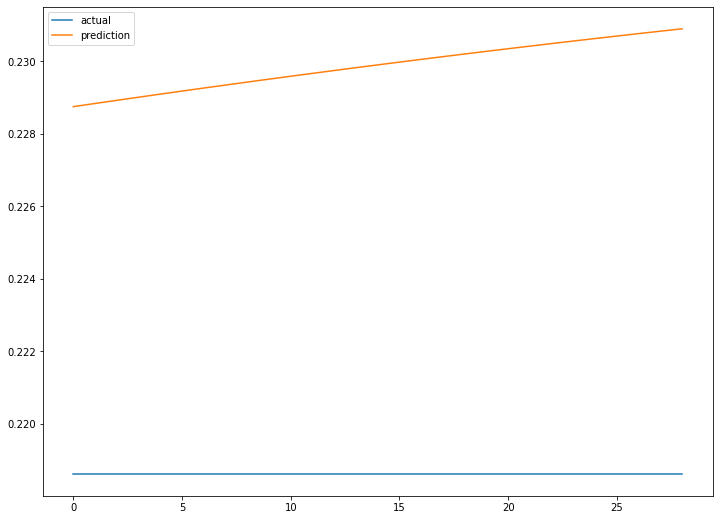

In [231]:
import matplotlib.pyplot as plt
pred = model.predict(X_test_3)
plt.figure(figsize=(12, 9))
plt.plot(Y_test_3, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()